# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет.

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
#import category_encoders as ce
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('Data/persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [ ]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

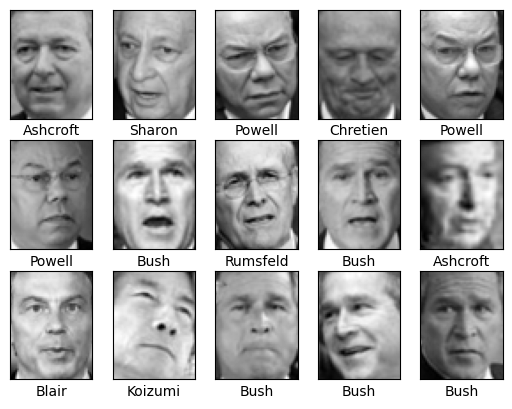

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

Крупнее

(-0.5, 46.5, 61.5, -0.5)

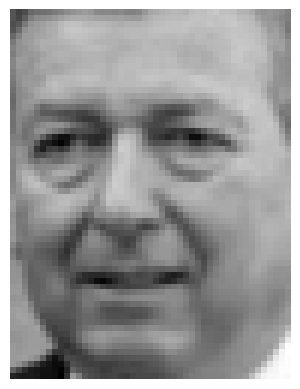

In [ ]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [ ]:
print('Число различных людей:', len(df['label'].unique()))
print(df['label'].unique())

Число различных людей: 12
['John Ashcroft' 'Ariel Sharon' 'Colin Powell' 'Jean Chretien'
 'George W Bush' 'Donald Rumsfeld' 'Tony Blair' 'Junichiro Koizumi'
 'Gerhard Schroeder' 'Hugo Chavez' 'Serena Williams' 'Jacques Chirac']


Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса.

In [ ]:
df["label"].value_counts(normalize=True)

George W Bush        0.340121
Colin Powell         0.151584
Tony Blair           0.092006
Donald Rumsfeld      0.077677
Gerhard Schroeder    0.070136
Ariel Sharon         0.049020
Hugo Chavez          0.045249
Junichiro Koizumi    0.038462
Jean Chretien        0.035445
John Ashcroft        0.033937
Serena Williams      0.033183
Jacques Chirac       0.033183
Name: label, dtype: float64

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [ ]:
vector = df.groupby('label')[df.drop(['label'], axis=1).columns].mean()
vector = vector.reset_index()
print(vector)

                label         0         1         2         3         4  \
0        Ariel Sharon  0.501398  0.514811  0.532609  0.551714  0.569754   
1        Colin Powell  0.433512  0.441147  0.456248  0.471947  0.486730   
2     Donald Rumsfeld  0.404810  0.417260  0.442731  0.474028  0.507938   
3       George W Bush  0.348179  0.360263  0.381659  0.416669  0.457154   
4   Gerhard Schroeder  0.210162  0.228210  0.268255  0.328344  0.389332   
5         Hugo Chavez  0.206885  0.205142  0.240828  0.300806  0.370196   
6      Jacques Chirac  0.348010  0.368152  0.405704  0.436988  0.462686   
7       Jean Chretien  0.388958  0.412488  0.446614  0.487637  0.526158   
8       John Ashcroft  0.337894  0.334379  0.337662  0.357037  0.384779   
9   Junichiro Koizumi  0.268384  0.253672  0.249699  0.257875  0.297373   
10    Serena Williams  0.412983  0.390434  0.359091  0.333541  0.337136   
11         Tony Blair  0.327922  0.342955  0.363163  0.401854  0.456177   

           5         6  

Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [ ]:
# < ENTER YOUR CODE HERE >

Используя усредненные векторы, постройте изображения всех людей из набора данных.

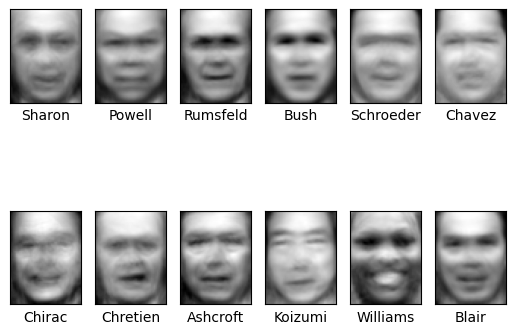

In [ ]:
fig, ax = plt.subplots(2, 6)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(vector.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

<Axes: >

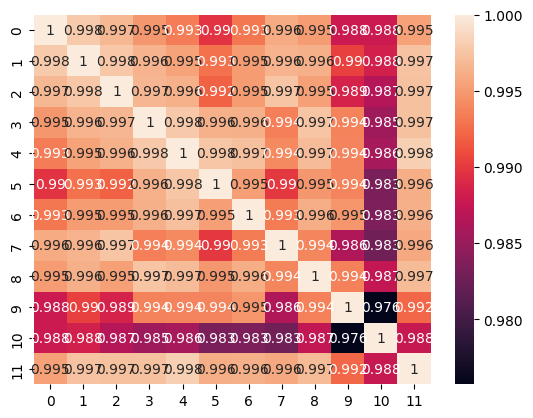

In [ ]:
# < ENTER YOUR CODE HERE >
from sklearn.metrics.pairwise import cosine_similarity
#cosine_similarity(df)
#print(vector.set_index('label'))
sns.heatmap(cosine_similarity(vector.set_index('label')), annot = True, fmt='.3g')

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [ ]:
# < ENTER YOUR CODE HERE >

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [ ]:
from sklearn.svm import SVC
x_train, x_test, y_train, y_test = train_test_split(df.drop(['label'], axis=1), df['label'], test_size=0.2, random_state=13, stratify=df['label'])

svm = SVC(kernel='linear', random_state=13)
svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)

print(f1_score(y_test, y_pred, average='weighted'))


0.8075550596460565


## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [ ]:
# < ENTER YOUR CODE HERE >

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
# < ENTER YOUR CODE HERE >

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [ ]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[13]}]


cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(x_train, y_train)

print('best score: ', cv.best_score_)
print('best param: ', cv.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.783 total time=   1.2s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.821 total time=   1.2s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.764 total time=   1.2s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.759 total time=   1.2s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.736 total time=   1.2s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=13;, score=0.363 total time=   2.5s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=13;, score=0.358 total time=   1.4s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=13;, score=0.358 total time=   1.4s
[CV 4/5] END C=1, class_weight=N

Определите гиперпараметры лучшей полученной модели.

In [ ]:
C = cv.best_params_['C']
kernel = cv.best_params_['kernel']
gamma = cv.best_params_['gamma']
class_weight = cv.best_params_['class_weight']

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [ ]:
svm = SVC(C=C, kernel=kernel, gamma=gamma, class_weight=class_weight, random_state=13)
svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)

print(f1_score(y_test, y_pred, average='weighted'))

0.8153472449345439


## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [ ]:
from sklearn.decomposition import PCA
#n_components = 100
#pca = PCA(n_components=n_components, svd_solver='full')
#pca.fit(x_train)

# получение доли объясненой дисперсии
#explained_var_ratio_1 = pca.explained_variance_ratio_[0]
#explained_var_ratio_2 = pca.explained_variance_ratio_[1]

n_components = 0
explained_var_ratio = 0

while explained_var_ratio < 0.95:
  n_components += 1
  pca = PCA(n_components=n_components, svd_solver='full')
  pca.fit(x_train)
  #n_components += 1
  explained_var_ratio = pca.explained_variance_ratio_.sum()

print("Доля объясненной дисперсии для ", n_components, " первой главной компоненты:", pca.explained_variance_ratio_.sum())

Доля объясненной дисперсии для  174  первой главной компоненты: 0.9502581855574563


Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [ ]:
pca = PCA(n_components=173, svd_solver='full')
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [ ]:
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(x_train_pca, y_train)

print('best score: ', cv.best_score_)
print('best param: ', cv.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.774 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.811 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.778 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.764 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=13;, score=0.722 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=13;, score=0.340 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=13;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=13;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=N

Определите гиперпараметры лучшей полученной модели.

In [ ]:
C = cv.best_params_['C']
kernel = cv.best_params_['kernel']
gamma = cv.best_params_['gamma']
class_weight = cv.best_params_['class_weight']

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
svm = SVC(C=C, kernel=kernel, gamma=gamma, class_weight=class_weight, random_state=13)
svm.fit(x_train_pca, y_train)

y_pred = svm.predict(x_test_pca)

print(f1_score(y_test, y_pred, average='weighted'))

0.8147394395247998


Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.